In [52]:
# Import dependencies
import torch
from torch import nn

torch.__version__

'2.2.1'

In [ ]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"Folder {image_path} already exists.")
else:
    print(f"Downloading and extracting images to {image_path}...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading from {request.url}")
    f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)


Folder data\pizza_steak_sushi already exists.
Unzipping...


In [6]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its files.
    """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

image_path


WindowsPath('data/pizza_steak_sushi')

Image path: data\pizza_steak_sushi\train\pizza\667309.jpg
Image class: pizza
Image size: (512, 384)


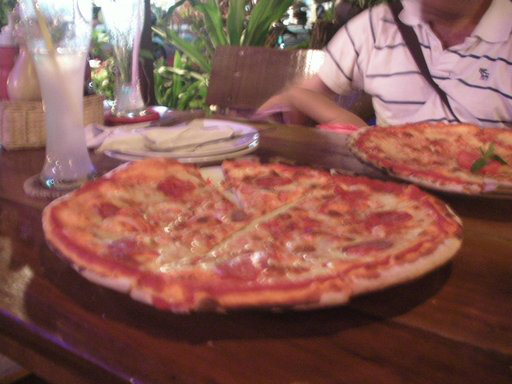

In [47]:
import random
from PIL import Image

#random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Select a random image
random_image_path = random.choice(image_path_list)

# Get image class name from the path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image size: {img.size}")
img

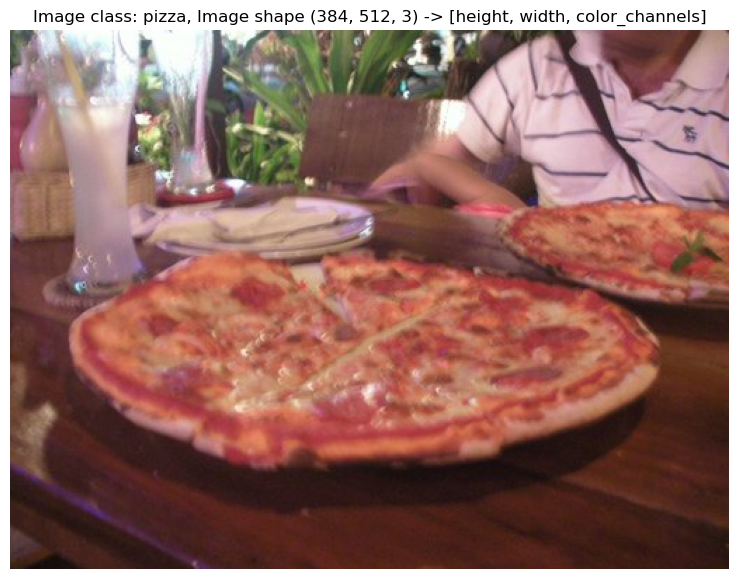

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}, Image shape {img_as_array.shape} -> [height, width, color_channels]") # PyTorch expects color channels first e.g. [3, 224, 224]
plt.axis('off'); # Turn off the axes

### Transforming data

In [53]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [57]:
data_transform = transforms.Compose([
    # Resize the images to 64,64
    transforms.Resize((64,64)),
    # FLip images randomly horizontally
    transforms.RandomHorizontalFlip(0.5),
    # Turn the images into PyTorch tensors
    transforms.ToTensor()
])

data_transform(img).dtype

torch.float32

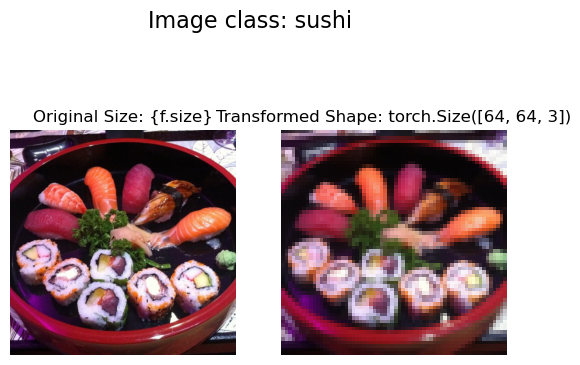

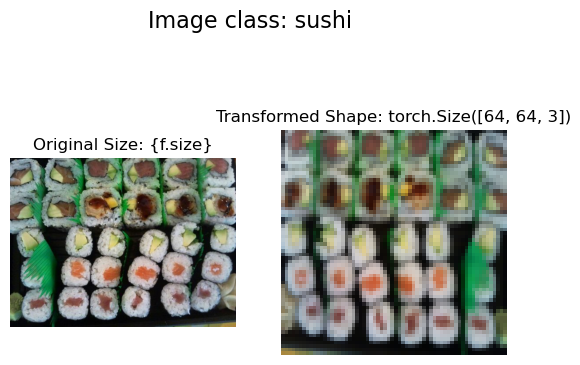

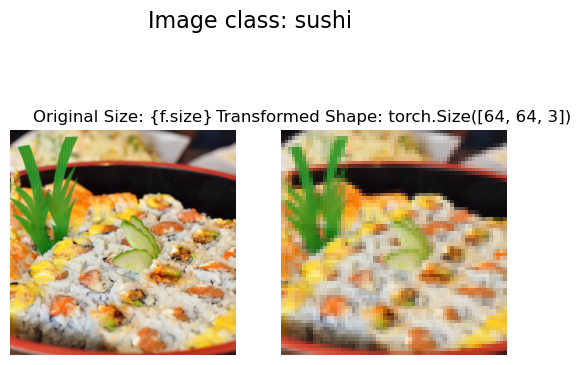

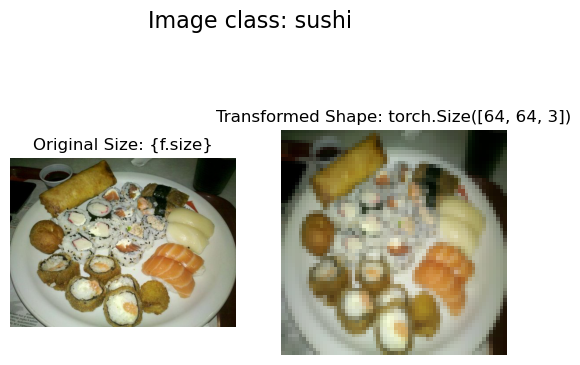

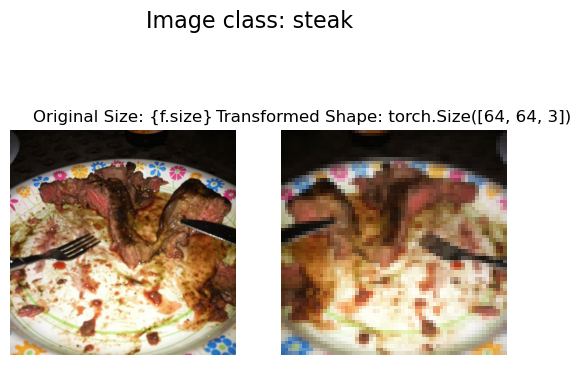

In [62]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Picks n random images from image_paths and displays them along with their transformed versions.
    """
    # Set the random seed
    #if seed:
    #    random.seed(seed)
    
    random_image_paths = random.sample(image_paths, n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title("Original Size: {f.size}")
            ax[0].axis("off")

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Shape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        data_transform,
                        n=5,
                        seed=42)

In [63]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                    transform=data_transform,
                                    target_transform=None)


test_data = datasets.ImageFolder(root=test_dir,
                                    transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [64]:
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [66]:
class_dict = train_data.class_to_idx

class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [67]:
len(train_data), len(test_data)

(225, 75)

In [70]:
# Index on the train dataset to get a single image and label

img, label = train_data[0][0], train_data[0][1]


print(f"Image shape: {img.shape}")
print(f"Image label: {label}")
print(f"Image data type: {img.dtype}")
print(f"Image class: {class_names[label]}")
print(f"Image label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image label: 0
Image data type: torch.float32
Image class: pizza
Image label datatype: <class 'int'>


In [73]:
# Reaaranage the image tensor shape to [height, width, color_channels]
img_permuted = img.permute(1, 2, 0)

print(f"Image shape: {img_permuted.shape}")

Image shape: torch.Size([64, 64, 3])


In [74]:
# Turn loaded images into dataloaders
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)

test_dataloader = DataLoader(test_data,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2bf638f3010>,
 <torch.utils.data.dataloader.DataLoader at 0x2bf5d951110>)

In [75]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [76]:
img, label = next(iter(train_dataloader))

print(f"Image batch shape: {img.shape}")
print(f"Image batch label shape: {label.shape}")
print(f"Image batch label datatype: {label.dtype}")


Image batch shape: torch.Size([32, 3, 64, 64])
Image batch label shape: torch.Size([32])
Image batch label datatype: torch.int64


In [82]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



In [79]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))


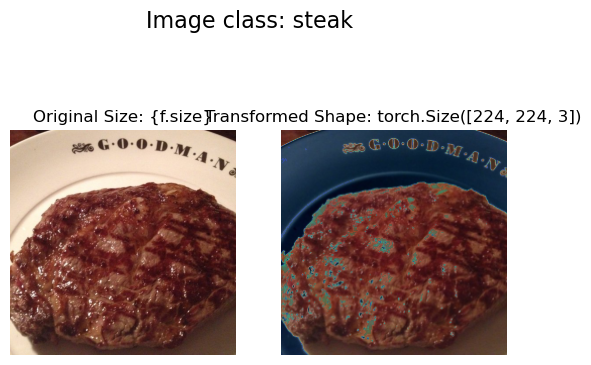

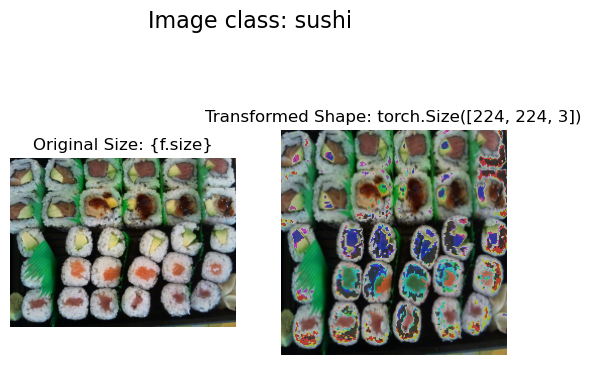

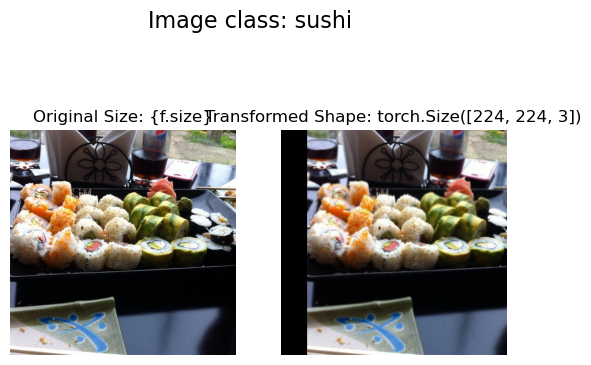

In [88]:
# Plot random images

plot_transformed_images(image_path_list,
                        train_transform,
                        n=3,
                        seed=None)

In [ ]:
# Replicate TinyVGG model with data augmentation

In [89]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [92]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)



In [124]:
# Create TinyVGG model class

class TinyVGG(nn.Module):
    """
    A simplified VGG-style convolutional neural network
    """

    def __init__(self, input_shape: int,
                hidden_units: int,
                output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 169,
                        out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [126]:
# testa  forward pass

image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [127]:
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6317e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8268e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [128]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [141]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [143]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [145]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set epochs
NUM_EPOCHS = 20

# Create TinyVGG instance
model_0 = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Start time
from timeit import default_timer as timer
start_time = timer()

# Train the model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End time
end_time = timer()
print(f"Time taken: {end_time - start_time}")

  5%|▌         | 1/20 [00:07<02:27,  7.77s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3116


 10%|█         | 2/20 [00:15<02:19,  7.78s/it]

Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3320 | test_loss: 1.0699 | test_acc: 0.5417


 15%|█▌        | 3/20 [00:23<02:11,  7.75s/it]

Epoch: 3 | train_loss: 1.0863 | train_acc: 0.4922 | test_loss: 1.0801 | test_acc: 0.5227


 20%|██        | 4/20 [00:31<02:04,  7.76s/it]

Epoch: 4 | train_loss: 1.0826 | train_acc: 0.4102 | test_loss: 1.0599 | test_acc: 0.5729


 25%|██▌       | 5/20 [00:38<01:56,  7.75s/it]

Epoch: 5 | train_loss: 1.0628 | train_acc: 0.4141 | test_loss: 1.0608 | test_acc: 0.5540


 30%|███       | 6/20 [00:46<01:48,  7.74s/it]

Epoch: 6 | train_loss: 1.0210 | train_acc: 0.4609 | test_loss: 1.0062 | test_acc: 0.4820


 35%|███▌      | 7/20 [00:54<01:40,  7.75s/it]

Epoch: 7 | train_loss: 0.9653 | train_acc: 0.4297 | test_loss: 0.9287 | test_acc: 0.6042


 40%|████      | 8/20 [01:02<01:33,  7.75s/it]

Epoch: 8 | train_loss: 0.9166 | train_acc: 0.5469 | test_loss: 1.0501 | test_acc: 0.4754


 45%|████▌     | 9/20 [01:09<01:25,  7.75s/it]

Epoch: 9 | train_loss: 0.9081 | train_acc: 0.6172 | test_loss: 1.1063 | test_acc: 0.3636


 50%|█████     | 10/20 [01:17<01:17,  7.79s/it]

Epoch: 10 | train_loss: 0.9781 | train_acc: 0.4805 | test_loss: 0.9981 | test_acc: 0.4337


 55%|█████▌    | 11/20 [01:25<01:09,  7.77s/it]

Epoch: 11 | train_loss: 0.8455 | train_acc: 0.6523 | test_loss: 0.9734 | test_acc: 0.5833


 60%|██████    | 12/20 [01:32<01:01,  7.71s/it]

Epoch: 12 | train_loss: 0.9465 | train_acc: 0.4297 | test_loss: 0.9390 | test_acc: 0.5644


 65%|██████▌   | 13/20 [01:40<00:53,  7.68s/it]

Epoch: 13 | train_loss: 0.7722 | train_acc: 0.6367 | test_loss: 1.0121 | test_acc: 0.4129


 70%|███████   | 14/20 [01:48<00:46,  7.67s/it]

Epoch: 14 | train_loss: 0.9137 | train_acc: 0.5312 | test_loss: 1.0705 | test_acc: 0.3731


 75%|███████▌  | 15/20 [01:55<00:38,  7.66s/it]

Epoch: 15 | train_loss: 0.7740 | train_acc: 0.7070 | test_loss: 0.9967 | test_acc: 0.5142


 80%|████████  | 16/20 [02:03<00:30,  7.64s/it]

Epoch: 16 | train_loss: 0.7347 | train_acc: 0.6992 | test_loss: 1.0000 | test_acc: 0.5038


 85%|████████▌ | 17/20 [02:11<00:22,  7.64s/it]

Epoch: 17 | train_loss: 0.7472 | train_acc: 0.6953 | test_loss: 1.0335 | test_acc: 0.4744


 90%|█████████ | 18/20 [02:18<00:15,  7.64s/it]

Epoch: 18 | train_loss: 0.7177 | train_acc: 0.6641 | test_loss: 1.0846 | test_acc: 0.4233


 95%|█████████▌| 19/20 [02:26<00:07,  7.62s/it]

Epoch: 19 | train_loss: 0.7428 | train_acc: 0.7227 | test_loss: 1.0694 | test_acc: 0.4545


100%|██████████| 20/20 [02:33<00:00,  7.69s/it]

Epoch: 20 | train_loss: 0.7412 | train_acc: 0.6562 | test_loss: 1.0769 | test_acc: 0.4953
Time taken: 153.89231120000477


In [146]:
# Plot the loss curves of model_0

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [149]:
def plot_loss_curves(results: dict[str, list[float]]):
    """
    Plots the loss and accuracy curves for the model
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss vs epochs")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy vs epochs")
    plt.xlabel("Epochs")
    plt.legend()

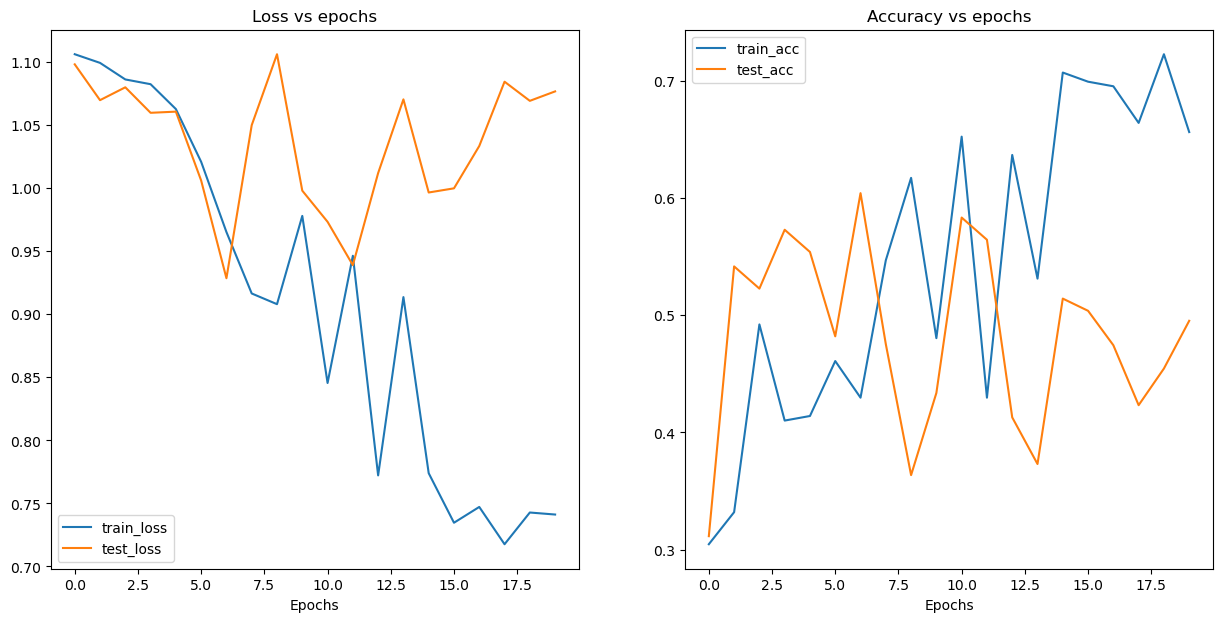

In [150]:
plot_loss_curves(model_0_results)

In [154]:
# TinyVGG model with data augmentation

# Create training transform with TrivialAugmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [155]:
# Create train and test datasets and dataloaders with data augmentation

train_dataset_augmented = datasets.ImageFolder(root=train_dir,
                                        transform=train_transform_trivial,
                                        )

test_dataset_simple = datasets.ImageFolder(root=test_dir,
                                    transform=test_transform_simple)



In [156]:
# Turn our datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_dataset_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_dataset_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)



In [158]:
# Create TinyVGG instance (model_1)

model_1 = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_dataset_augmented.classes)).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Start time
start_time = timer()

NUM_EPOCHS = 20

# Train the model
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End time  
end_time = timer()
print(f"Time taken: {end_time - start_time}")

  5%|▌         | 1/20 [00:07<02:25,  7.68s/it]

Epoch: 1 | train_loss: 1.0958 | train_acc: 0.3164 | test_loss: 1.0983 | test_acc: 0.3438


 10%|█         | 2/20 [00:15<02:18,  7.71s/it]

Epoch: 2 | train_loss: 1.0856 | train_acc: 0.4492 | test_loss: 1.1092 | test_acc: 0.2812


 15%|█▌        | 3/20 [00:23<02:11,  7.73s/it]

Epoch: 3 | train_loss: 1.1065 | train_acc: 0.4141 | test_loss: 1.1187 | test_acc: 0.3333


 20%|██        | 4/20 [00:30<02:03,  7.74s/it]

Epoch: 4 | train_loss: 1.0725 | train_acc: 0.4375 | test_loss: 1.1029 | test_acc: 0.2708


 25%|██▌       | 5/20 [00:38<01:55,  7.73s/it]

Epoch: 5 | train_loss: 1.0282 | train_acc: 0.5664 | test_loss: 1.0683 | test_acc: 0.3617


 30%|███       | 6/20 [00:46<01:48,  7.73s/it]

Epoch: 6 | train_loss: 1.0012 | train_acc: 0.5586 | test_loss: 1.0732 | test_acc: 0.3324


 35%|███▌      | 7/20 [00:54<01:40,  7.74s/it]

Epoch: 7 | train_loss: 1.0364 | train_acc: 0.4102 | test_loss: 1.0732 | test_acc: 0.3210


 40%|████      | 8/20 [01:01<01:32,  7.75s/it]

Epoch: 8 | train_loss: 0.9405 | train_acc: 0.5117 | test_loss: 1.0084 | test_acc: 0.3409


 45%|████▌     | 9/20 [01:09<01:25,  7.74s/it]

Epoch: 9 | train_loss: 0.9434 | train_acc: 0.5859 | test_loss: 1.0299 | test_acc: 0.3324


 50%|█████     | 10/20 [01:17<01:17,  7.74s/it]

Epoch: 10 | train_loss: 0.9107 | train_acc: 0.5742 | test_loss: 1.0935 | test_acc: 0.3428


 55%|█████▌    | 11/20 [01:25<01:09,  7.73s/it]

Epoch: 11 | train_loss: 1.0459 | train_acc: 0.4844 | test_loss: 1.0038 | test_acc: 0.4337


 60%|██████    | 12/20 [01:32<01:01,  7.72s/it]

Epoch: 12 | train_loss: 1.0983 | train_acc: 0.4570 | test_loss: 0.9900 | test_acc: 0.5350


 65%|██████▌   | 13/20 [01:40<00:54,  7.73s/it]

Epoch: 13 | train_loss: 1.0195 | train_acc: 0.4609 | test_loss: 1.0860 | test_acc: 0.4034


 70%|███████   | 14/20 [01:48<00:46,  7.75s/it]

Epoch: 14 | train_loss: 1.0426 | train_acc: 0.4531 | test_loss: 1.1051 | test_acc: 0.4138


 75%|███████▌  | 15/20 [01:56<00:38,  7.75s/it]

Epoch: 15 | train_loss: 0.9553 | train_acc: 0.5742 | test_loss: 1.1849 | test_acc: 0.3125


 80%|████████  | 16/20 [02:03<00:30,  7.74s/it]

Epoch: 16 | train_loss: 1.0776 | train_acc: 0.4141 | test_loss: 1.1245 | test_acc: 0.3428


 85%|████████▌ | 17/20 [02:11<00:23,  7.74s/it]

Epoch: 17 | train_loss: 0.9190 | train_acc: 0.6016 | test_loss: 0.9932 | test_acc: 0.5559


 90%|█████████ | 18/20 [02:19<00:15,  7.75s/it]

Epoch: 18 | train_loss: 0.9812 | train_acc: 0.4766 | test_loss: 0.9550 | test_acc: 0.5436


 95%|█████████▌| 19/20 [02:26<00:07,  7.73s/it]

Epoch: 19 | train_loss: 0.9355 | train_acc: 0.5117 | test_loss: 0.9048 | test_acc: 0.6042


100%|██████████| 20/20 [02:34<00:00,  7.73s/it]

Epoch: 20 | train_loss: 1.0035 | train_acc: 0.4961 | test_loss: 0.9142 | test_acc: 0.5634
Time taken: 154.69329680000374


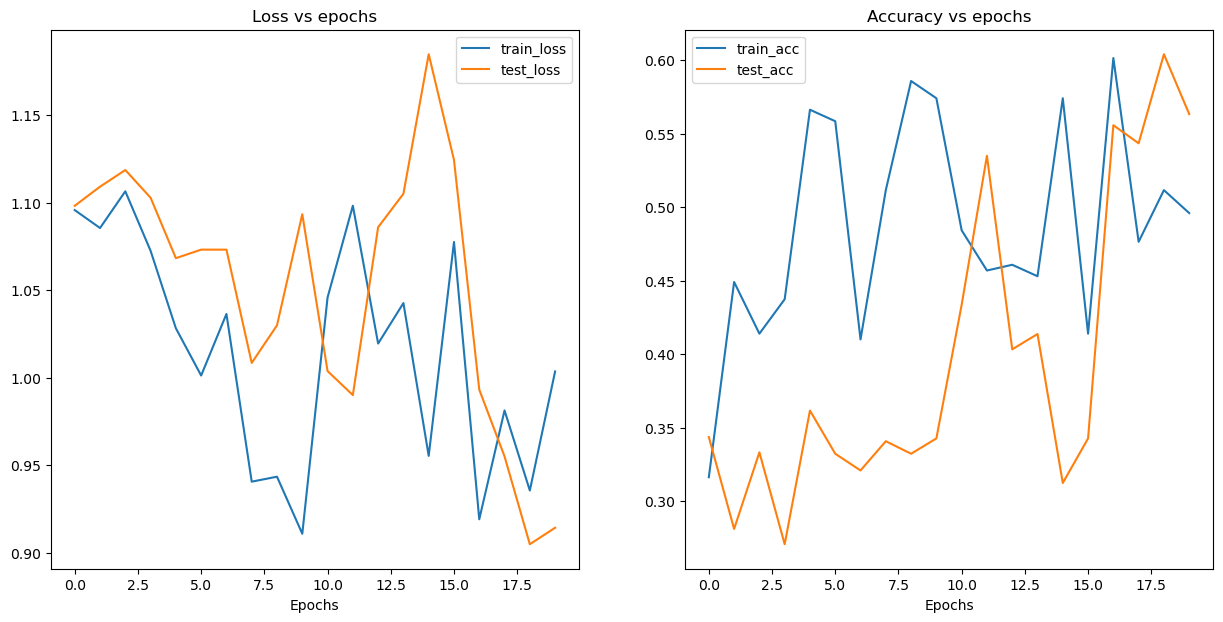

In [159]:

plot_loss_curves(model_1_results)

In [162]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)